# Predicting Eurovision Finalists results based on tweets

Script that reads tweets from a database and processes the information to predict the results of the Eurovision Song Contest.

In [72]:
import re
import sqlite3
import pandas as pd
from textblob import TextBlob
from collections import Counter
from random import randint

## Aux functions

In [24]:
def get_tweet_sentiment(tweet):
    """
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    """

    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet['tweetText']))
    
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [25]:
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

## Setup

In [74]:
# Setup sqlite
sqlite_file = 'eurovision_final.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [27]:
# set country hashtags - semifinal 1
all_hashtags = ['SWE', 'GEO', 'AUS', 'ALB', 'BEL', 'MNE', 'FIN', 'AZE', 'POR',\
                'POL', 'MDA', 'ISL', 'CZE', 'CYP', 'ARM', 'SLO', 'LAT', 'GRE',\
                'AUT', 'BLR', 'DEN', 'EST', 'MKD', 'HUN', 'IRL', 'ISR', 'LTU',\
                'NOR', 'ROM', 'SMR', 'SRB', 'SUI', 'NED', 'CRO', 'BUL', 'MLT',\
                'ITA', 'FRA', 'ESP', 'GBR', 'UKR', 'GER']

hashtags_semi1 = ['SWE', 'GEO', 'AUS', 'ALB', 'BEL', 'MNE', 'FIN', 'AZE', 'POR', 'GRE',\
                    'POL', 'MDA', 'ISL', 'CZE', 'CYP', 'ARM', 'SLO', 'LAT']

# set country hashtags - semifinal 2
hashtags_semi2 = ['AUT', 'BLR', 'DEN', 'EST', 'MKD', 'HUN', 'IRL', 'ISR', 'LTU', 'MLT', \
                    'NOR', 'ROM', 'SMR', 'SRB', 'SUI', 'NED', 'CRO', 'BUL']

# set country hashtags - final
hashtags_final = ['ARM', 'AZE', 'ITA', 'MDA', 'POL', 'POR', 'UKR', 'AUS', 'BEL', 'CYP', 'FRA',\
                  'GER', 'GRE', 'ESP', 'GBR', 'SWE', 'BUL', 'BLR', 'CRO', 'HUN', 'DEN',\
                  'ISR', 'ROM', 'NOR', 'NED', 'AUT']

hashtags = hashtags_semi1 + hashtags_semi2
print(len(hashtags))

36


## Count tweets and analyze sentiment

In [6]:
# read ALL tweets in english from db, evaluate sentiment, and count - SEMI 1
all_sentiments = []
for country in hashtags:

    # get tweets from DB
    country_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE language='en' AND tweetText LIKE '%#{}%'".format(country), connection)

    # count number of sentiments
    sentiments_count = Counter(country_tweets.apply(get_tweet_sentiment, axis=1))
    
    # append country to list
    all_sentiments.append({'country': country, \
                           'positive': sentiments_count['positive'],\
                           'neutral': sentiments_count['neutral'],\
                           'negative': sentiments_count['negative']
                          })

In [7]:
# read all tweets (to just count)
all_tweet_counts = []
for country in hashtags:

    # get tweet count from DB
    db.execute("SELECT COUNT(*) AS count FROM TweetsRaw WHERE tweetText LIKE '%#{}%'".format(country))
    country_tweet_count = db.fetchone()[0]
    
    # append country to list
    all_tweet_counts.append({'country': country, \
                           'count': country_tweet_count
                          })

In [8]:
# transform to pandas dataframe from sentiments list
results = pd.DataFrame(all_sentiments)
results = results.set_index(['country'])

# add total tweet count
results['tweets'] = [tc['count'] for tc in all_tweet_counts]

# add percentages of features over the totals
results['positive_perc'] = results['positive'] / results['positive'].sum()
results['negative_perc'] = results['negative'] / results['negative'].sum()
results['neutral_perc'] = results['neutral'] / results['neutral'].sum()
results['tweets_perc'] = results['tweets'] / results['tweets'].sum()

In [9]:
# add finalist 'column'
results['finalist'] = 0

results.loc['MDA','finalist'] = 1
results.loc['AZE','finalist'] = 1
results.loc['GRE','finalist'] = 1
results.loc['SWE','finalist'] = 1
results.loc['POR','finalist'] = 1
results.loc['POL','finalist'] = 1
results.loc['ARM','finalist'] = 1
results.loc['AUS','finalist'] = 1
results.loc['CYP','finalist'] = 1
results.loc['BEL','finalist'] = 1
results.loc['BUL','finalist'] = 1
results.loc['BLR','finalist'] = 1
results.loc['CRO','finalist'] = 1
results.loc['HUN','finalist'] = 1
results.loc['DEN','finalist'] = 1
results.loc['ISR','finalist'] = 1
results.loc['ROM','finalist'] = 1
results.loc['NOR','finalist'] = 1
results.loc['NED','finalist'] = 1
results.loc['AUT','finalist'] = 1

## Prediction model

### Feature engineering

In [83]:
# create normalized features
results['negative_norm'] = (results['negative'] - results['negative'].mean() ) / results['negative'].std()
results['neutral_norm'] = (results['neutral'] - results['neutral'].mean() ) / results['neutral'].std()
results['positive_norm'] = (results['positive'] - results['positive'].mean() ) / results['positive'].std()
results['tweets_norm'] = (results['tweets'] - results['tweets'].mean() ) / results['tweets'].std()
#results['negative_norm'] = results['negative'] / results['negative'].sum()
#results['neutral_norm'] = results['neutral'] / results['neutral'].sum()
#results['positive_norm'] = results['positive'] / results['positive'].sum()
#results['tweets_norm'] = results['tweets'] / results['tweets'].sum()

# create log features
results['negative_log'] = np.log(1 + results['negative_perc'])
results['neutral_log'] = np.log(1 + results['neutral_perc'])
results['positive_log'] = np.log(1 + results['positive_perc'])
results['tweets_log'] = np.log(1 + results['tweets_perc'])

### Train Model

In [102]:
# set the features to analyze in the model
features = ['negative_log', 'neutral_log', 'positive_log', 'tweets_log']
#features = ['negative_norm', 'neutral_norm', 'positive_norm', 'tweets_norm']
#features = ['negative_log', 'neutral_log', 'positive_log', 'tweets_log', \
#            'negative_norm', 'neutral_norm', 'positive_norm', 'tweets_norm']
features_string = ' + '.join(features)

In [103]:
# create input matrix and outut array
y, X = dmatrices('finalist ~ {}'.format(features_string), results, return_type = 'dataframe')

#### Logistic Regression Classifier

In [107]:
import numpy as np
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
import sklearn.linear_model as lm

best_score = 0
for it in range(0,100):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,1000))

    # Logistic Regression model with sklearn
    regularization = 0.001
    model = lm.LogisticRegression(fit_intercept = False, C = 1/regularization)
    classifier = model.fit(X_train, y_train.values.ravel())

    # print results if best score so far
    score = classifier.score(X_test, y_test)
    if score >= best_score:
        print(classifier.coef_, classifier.score(X_test, y_test))
        best_score = score

[[ -0.05035294 -24.682529     1.95287805  19.18785507  12.02347988]] 0.875
[[  0.10516202 -21.41942666   3.46204239   6.83032191   9.6334635 ]] 0.875
[[ -0.07559544 -17.58394658   2.35064451  16.89248464  12.50045079]] 0.875
[[  1.47652550e-02  -1.72236421e+01  -1.64265073e+00   1.26120143e+01
    1.26697413e+01]] 0.875
[[  3.60854143e-03  -1.64930061e+01  -8.34671418e+00   2.17190026e+01
    9.66318404e+00]] 0.875
[[ -0.07420078 -22.76248969   0.76440756  16.07724795  10.94839982]] 0.875
[[  1.84399964e-02  -2.13820138e+01   5.12443718e+00   8.85120417e+00
    1.29684041e+01]] 1.0


#### Naive Bayes Classifier

In [108]:
import numpy as np
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB

best_score = 0
for it in range(0,100):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,1000))

    # Create a Gaussian Classifier and train the model
    model = GaussianNB()
    classifier = model.fit(X_train, y_train.values.ravel())

    # print results if best score so far
    score = classifier.score(X_test, y_test)
    if score >= best_score:
        print(classifier.score(X_test, y_test))
        best_score = score

0.375
0.5
0.625
0.625
0.625
0.75
0.75
0.875


#### Decision Tree Classifier

In [112]:
import numpy as np
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn import tree

best_score = 0
for it in range(0,100):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,1000))

    # Create a Gaussian Classifier and train the model
    model = tree.DecisionTreeClassifier()
    classifier = model.fit(X_train, y_train.values.ravel())

    # print results if best score so far
    score = classifier.score(X_test, y_test)
    if score >= best_score:
        print(classifier.score(X_test, y_test))
        best_score = score

0.5
0.5
0.75
0.875
0.875
1.0


### Tweet Timelines


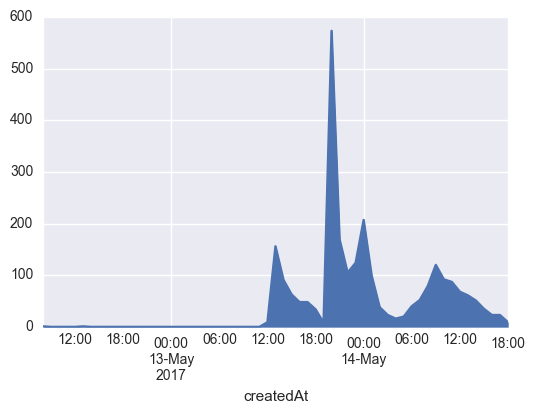

In [75]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

tweets = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE TweetText LIKE '%#ESP %' AND TweetText LIKE 'RT %'", connection)

tweets['createdAt'] = pd.to_datetime(tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
tweets.index = tweets['createdAt']
tweets.resample('H').count()['id'].plot(kind='area')

### Filter tweets by date

In [76]:
# read from db
tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')

# filter tweets until 'Stop voting now at 23:47'
tweets_only_final = tweets[tweets['createdAt'] < '2017-05-13 21:47']

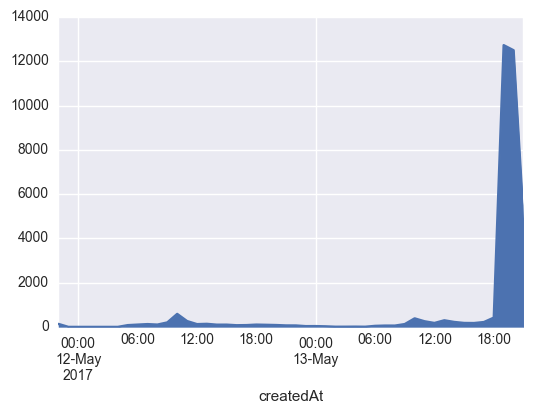

In [77]:
# plot
tweets_only_final.index = tweets_only_final['createdAt']
tweets_only_final.resample('H').count()['id'].plot(kind='area')

In [78]:
# store to db
sqlite_file = 'eurovision_final_2.db'
connection = sqlite3.connect(sqlite_file)
del tweets_only_final['createdAt']
tweets_only_final.reset_index()
tweets_only_final.to_sql("TweetsRaw", connection, if_exists="replace")